# Modeling Results

In this notebook, we load the cross validation scores for all models and try to compare their performance. For reviews' convinience, we also list descriptions for all the folders/codes we have in the project as follows.

1. write_up/   

Project proposal write-up and final write-up, as well as powerpoint slides used for in-class presentations.

2. codes/   

ClassifierWrapper.py   
Wrapper for all classifiers used in the project.     

Vectorizer.py   
Wrapper for all vectorizer used in the project.

TextClassifier.py   
A class that is initialized with classifiers from ClassifierWrapper.py and vectorizers from Vectorizer.py. Classifiers and vectorizers are passed into the constructor of this class as lists. That means, more than one kind of classifiers/vectorizers can be passed into this class. In such case, the probability outputs of all classifiers are averaged and provided as the final probability prediction. This class also provide a method to do k-fold cross-validation and return a dataframe of relevant scores. The scores are stored to disk if a folder is specified.

evaluate_models.py   
This file documents the models that we have trained other than CNN.

evaluate_models_deepnn.py   
This file documents exclusively training of CNN models.

normailization.py   
This file documents the steps taken to normailze the news body. This file will normalize the text found in "real_fake_news.csv" that is generated in News_DataPrep_EDA.ipynb.

ModelingResults.ipynb   
A notebook that shows the comparison of accuracies of all the models that we have trained, as well as a simple case analysis on the texts that get classified incorrectly. Note that because the models are too big to save in github, reviewer of this project will not be able to load the models that we have trained during the project. We suggest to look directly at the results instead of trying to run this notebook.

News_DataPrep_EDA.ipynb   
A notebook that documents the steps to generate the dataset "real_fake_news.csv" used in normalization.py. It also contains some exploratory data visualization. In order to run this notebook, you will also need to download news dataset from these two sources:   
https://www.kaggle.com/snapcrack/all-the-news/home   
https://www.kaggle.com/mrisdal/fake-news   
And put them into "data" folder.   

3. saved_models/   

This folder save the cross_validation scores for all models.

4. wordvecs/    

This folder stores the pretrained word vectors downloaded from the web and used in this project. We have used the following two pretrained word vectors in our experiments:     
fastText:   
https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki-news-300d-1M.vec.zip   
GloVe:    
kaggle datasets download -d rdizzl3/glove6b50d

5. data/   

Data used in this project. Github does not allow files that have size >100MB to be uploaded. Therefor, to repeat the results and run codes/notbooks, you need to uncompress the files stored in this folder.

## 1. Load saved cross-validation results into memory

We have saved cross-validation results for all models in "saved_models".

In [91]:
import pickle
import pandas as pd
import numpy as np
from ClassifierWrapper import *
from Vectorizer import *
from sklearn.model_selection import train_test_split
from sklearn import metrics
from TextClassifier import TextClassifier
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
model_set = {
    "ensemble_fasttext_cnn_cntvecnb_lr": {
        "vec": [VectorizerCountVecNB(),
                VectorizerEmbedding(docLen=5000,word_vector_file="../wordvecs/wiki-news-300d-1M.vec")],
        "clf": [LogisticRegressionWrapper(C=4, dual=True),
                CNNWrapper(docLen=5000)]
    },
    "fasttext_cnn": {
        "vec": [VectorizerCountVec()],
        "clf": [LogisticRegressionWrapper(C=4, dual=True)]
    },
    "glove_cnn": {
        "vec": [VectorizerEmbedding(docLen=5000,word_vector_file="../wordvecs/glove.6B.50d.txt")],
        "clf": [CNNWrapper(docLen=5000)]
    },
    "lr_cntvec": {
        "vec": [VectorizerCountVec()],
        "clf": [LogisticRegressionWrapper(C=4, dual=True)]
    },
    "lr_cntvecnb": {
        "vec": [VectorizerCountVecNB()],
        "clf": [LogisticRegressionWrapper(C=4, dual=True)]
    },
    "lr_tfidf": {
        "vec": [VectorizerTFIDF()],
        "clf": [LogisticRegressionWrapper(C=4, dual=True)]
    },
    "lr_tfidfnb": {
        "vec": [VectorizerTFIDFNB()],
        "clf": [LogisticRegressionWrapper(C=4, dual=True)]
    },
    "mnb_cntvec": {
        "vec": [VectorizerCountVec()],
        "clf": [MultinomialNBWrapper()]
    },
    "rf_cntvec": {
        "vec": [VectorizerCountVec()],
        "clf": [RandomForestClassifierWrapper(n_estimators=50,
                                              max_features=0.8,
                                              random_state=42,n_jobs=-1)]
    },
    "rf_cntvecnb": {
        "vec": [VectorizerCountVecNB()],
        "clf": [RandomForestClassifierWrapper(n_estimators=50,
                                              max_features=0.8,
                                              random_state=42,n_jobs=-1)]
    },
    "rf_tfidf": {
        "vec": [VectorizerTFIDF()],
        "clf": [RandomForestClassifierWrapper(n_estimators=50,
                                              max_features=0.8,
                                              random_state=42,n_jobs=-1)]
    },
    "rf_tfidfnb": {
        "vec": [VectorizerTFIDFNB()],
        "clf": [RandomForestClassifierWrapper(n_estimators=50,
                                              max_features=0.8,
                                              random_state=42,n_jobs=-1)]
    },
    "svmlinear_tfidf": {
        "vec": [VectorizerTFIDF()],
        "clf": [SVCWrapper(kernel='linear',probability=True)]
    },
    "svmlinear_tfidfnb": {
        "vec": [VectorizerTFIDFNB()],
        "clf": [SVCWrapper(kernel='linear',probability=True)]
    },
    "svmlinear_cntvec": {
        "vec": [VectorizerCountVec()],
        "clf": [SVCWrapper(kernel='linear',probability=True)]
    },
    "svmlinear_cntvecnb": {
        "vec": [VectorizerCountVecNB()],
        "clf": [SVCWrapper(kernel='linear',probability=True)]
    },
    "lrbagging_tfidf": {
        "vec": [VectorizerTFIDF()],
        "clf": [BaggingClassifierWrapper(base_estimator=LogisticRegression(),
                                         n_estimators=50,
                                         bootstrap=True,
                                         bootstrap_features=True,
                                         verbose=1,
                                         n_jobs=-1)]
    },
    "lrbagging_tfidfnb": {
        "vec": [VectorizerTFIDFNB()],
        "clf": [BaggingClassifierWrapper(base_estimator=LogisticRegression(),
                                         n_estimators=50,
                                         bootstrap=True,
                                         bootstrap_features=True,
                                         verbose=1,
                                         n_jobs=-1)]
    },
    "lrbagging_cntvec": {
        "vec": [VectorizerCountVec()],
        "clf": [BaggingClassifierWrapper(base_estimator=LogisticRegression(),
                                         n_estimators=50,
                                         bootstrap=True,
                                         bootstrap_features=True,
                                         verbose=1,
                                         n_jobs=-1)]
    },
    "lrbagging_cntvecnb": {
        "vec": [VectorizerCountVecNB()],
        "clf": [BaggingClassifierWrapper(base_estimator=LogisticRegression(),
                                         n_estimators=50,
                                         bootstrap=True,
                                         bootstrap_features=True,
                                         verbose=1,
                                         n_jobs=-1)]
    }
}


In [3]:
# Read data
np.random.seed(0)
df = pd.read_csv("../data/normalized_texts_labels.csv",encoding="utf-8")
df = df[["normalized_title","normalized_text","fake"]]
df.columns = ["titles","texts","labels"]
print("# of NaN of texts:" + str(df["texts"].isnull().sum()))
print("# of NaN of labels:" + str(df["labels"].isnull().sum()))
print("# of NaN of titles:" + str(df["titles"].isnull().sum()))
df = df.dropna()
y = df["labels"].values
X = df["texts"].values
X, X_test, y, y_test = train_test_split(X, y, stratify=y, random_state=12345, test_size=0.2, shuffle=True)

# of NaN of texts:109
# of NaN of labels:0
# of NaN of titles:7


In [4]:
cv_scores_summary = pd.DataFrame(columns=["model_name","metric_name","mean","std"])
for k,v in model_set.items():
    model_name = k
    saved_folder = "../saved_models/" + model_name
    cv_score_file_name = saved_folder + "/" + "cv_score.pickle"
    cv_scores = pickle.load( open( cv_score_file_name, "rb" ) )
    cv_scores = cv_scores[["mean","std"]]
    cv_scores.index.name = ""
    cv_scores.columns.name = ""
    cv_scores = cv_scores[cv_scores.index.str.contains("val")]
    for index, row in cv_scores.iterrows():
        #print(index,row)
        cv_scores_summary = cv_scores_summary.append({'model_name' : model_name,
                                  'metric_name' : index,
                                  "mean": row["mean"],
                                  "std": row["std"]
                                  } , ignore_index=True)

In [5]:
scores_name = ["acc","auc","f1","precision","recall"]
score_summary_each_type = {}
for score in scores_name:
    score_summary_each_type[score] = \
        cv_scores_summary[cv_scores_summary["metric_name"].str.contains(score)]

## 2. Model performance comparisons
We only compared at cross-validation accuracies and AUC scores, as there is no other criteria that prompts us to use other kinds of metrics at this point.

### Accuracies

In [6]:
score_summary_each_type["acc"].sort_values("model_name")

,model_name,metric_name,mean,std
0,ensemble_fasttext_cnn_cntvecnb_lr,val_acc,0.972153,0.002986
5,fasttext_cnn,val_acc,0.962525,0.004542
10,glove_cnn,val_acc,0.934581,0.010676
15,lr_cntvec,val_acc,0.941474,0.002805
20,lr_cntvecnb,val_acc,0.959079,0.003826
25,lr_tfidf,val_acc,0.947468,0.003143
30,lr_tfidfnb,val_acc,0.953414,0.004088
90,lrbagging_cntvec,val_acc,0.941285,0.004136
95,lrbagging_cntvecnb,val_acc,0.957993,0.002768
80,lrbagging_tfidf,val_acc,0.927031,0.002776


### AUC scores

In [7]:
score_summary_each_type["auc"].sort_values("model_name")

,model_name,metric_name,mean,std
1,ensemble_fasttext_cnn_cntvecnb_lr,val_auc,0.996096,0.000714
6,fasttext_cnn,val_auc,0.994364,0.000535
11,glove_cnn,val_auc,0.986661,0.001374
16,lr_cntvec,val_auc,0.981320,0.001573
21,lr_cntvecnb,val_auc,0.989219,0.001565
26,lr_tfidf,val_auc,0.987065,0.000835
31,lr_tfidfnb,val_auc,0.990317,0.000880
91,lrbagging_cntvec,val_auc,0.984499,0.001247
96,lrbagging_cntvecnb,val_auc,0.991151,0.000898
81,lrbagging_tfidf,val_auc,0.979022,0.001379


### Accuracies sorted

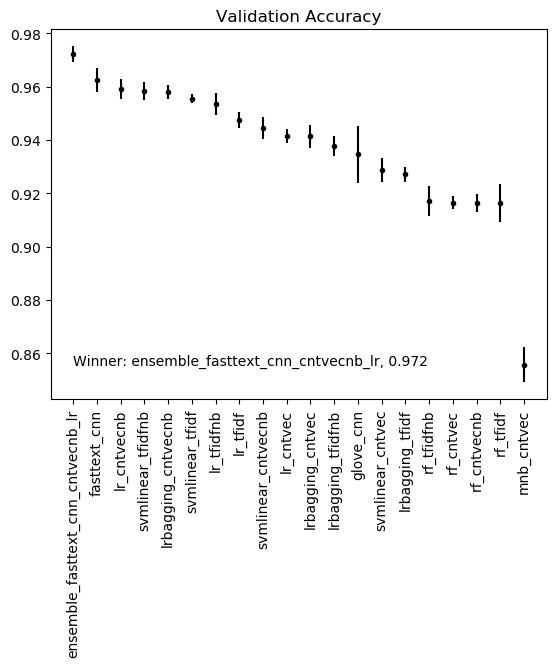

In [8]:
score_summary_each_type["acc"] = \
    score_summary_each_type["acc"].sort_values("mean",ascending=False)
df_toplot = score_summary_each_type["acc"]
plt.rcdefaults()
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.errorbar(np.arange(len(df_toplot["mean"])), list(df_toplot["mean"]), 
             yerr=list(df_toplot["std"]), fmt='.k')
ax.set_xticks(np.arange(len(df_toplot["mean"])))
ax.set_xticklabels(df_toplot["model_name"],rotation='vertical')
ax.set_title("Validation Accuracy")
plt.text(0, list(df_toplot["mean"])[-1], 
                 'Winner: ' +
                 list(df_toplot["model_name"])[0] +
                 ', %.3f' % list(df_toplot["mean"])[0])
plt.show()

In [90]:
score_summary_each_type["acc"]

,model_name,metric_name,mean,std
0,ensemble_fasttext_cnn_cntvecnb_lr,val_acc,0.972153,0.002986
5,fasttext_cnn,val_acc,0.962525,0.004542
20,lr_cntvecnb,val_acc,0.959079,0.003826
65,svmlinear_tfidfnb,val_acc,0.958370,0.003431
95,lrbagging_cntvecnb,val_acc,0.957993,0.002768
60,svmlinear_tfidf,val_acc,0.955397,0.001683
30,lr_tfidfnb,val_acc,0.953414,0.004088
25,lr_tfidf,val_acc,0.947468,0.003143
75,svmlinear_cntvecnb,val_acc,0.944400,0.004103
15,lr_cntvec,val_acc,0.941474,0.002805


### AUC scores sorted

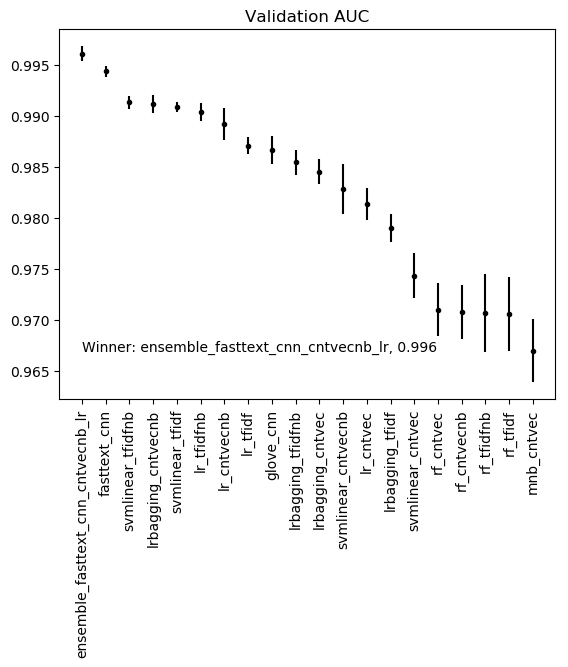

In [9]:
score_summary_each_type["auc"] = \
    score_summary_each_type["auc"].sort_values("mean",ascending=False)
df_toplot = score_summary_each_type["auc"]
plt.rcdefaults()
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.errorbar(np.arange(len(df_toplot["mean"])), list(df_toplot["mean"]), 
             yerr=list(df_toplot["std"]), fmt='.k')
ax.set_xticks(np.arange(len(df_toplot["mean"])))
ax.set_xticklabels(df_toplot["model_name"],rotation='vertical')
ax.set_title("Validation AUC")
plt.text(0, list(df_toplot["mean"])[-1], 
                 'Winner: ' +
                 list(df_toplot["model_name"])[0] +
                 ', %.3f' % list(df_toplot["mean"])[0])
plt.show()

## 3. Best model on the test set
We see that the following model perform the best based on cross-validation results:

Ensemble model:
(1)fastText + CNN
(2)Naïve Bayesian Count-Vectors + Logistic Regression

That is, the model "ensemble_fasttext_cnn_cntvecnb_lr"
We now evaluate on the test set.

In [10]:
model_name = "ensemble_fasttext_cnn_cntvecnb_lr"
saved_folder = "../saved_models/" + model_name
tc = TextClassifier(vectorizerList=model_set[model_name]["vec"],
                    classifierList=model_set[model_name]["clf"])
tc.load_models(saved_folder)
pred_test = tc.predict(X_test)

loading models and vectorizer from ../saved_models/ensemble_fasttext_cnn_cntvecnb_lr
loading model from ../saved_models/ensemble_fasttext_cnn_cntvecnb_lr/0.model
loading vectorizer from ../saved_models/ensemble_fasttext_cnn_cntvecnb_lr/0.vec
loading model from ../saved_models/ensemble_fasttext_cnn_cntvecnb_lr/1.model
loading vectorizer from ../saved_models/ensemble_fasttext_cnn_cntvecnb_lr/1.vec


In [11]:
print("Accuracy on test set:")
print(metrics.accuracy_score(y_test, pred_test>0.5))
print("AUC score on test set:")
print(metrics.roc_auc_score(y_test, pred_test))

Accuracy on test set:
0.9730035869360015
AUC score on test set:
0.9965489638916499


## 4. Case analysis on best model

We first check the distribution of sentense length of all documents. It's not directly part of the case analysis. But rather a part of exploratory data analysis. The input dimensions of the CNN is determined to be clamped at 5000 words, based on this analysis.

In [83]:
# Reload data
np.random.seed(0)
df = pd.read_csv("../data/normalized_texts_labels.csv",encoding="utf-8")
df = df[["normalized_title","normalized_text","fake"]]
df.columns = ["titles","texts","labels"]
print("# of NaN of texts:" + str(df["texts"].isnull().sum()))
print("# of NaN of labels:" + str(df["labels"].isnull().sum()))
print("# of NaN of titles:" + str(df["titles"].isnull().sum()))
df = df.dropna()
# First need to do some additional processing on the texts because normalization is not good enough
df.texts = tc.additional_preprocess(df.texts)

y = df["labels"].values
X = df["texts"].values
X, X_test, y, y_test = train_test_split(X, y, stratify=y, random_state=12345, test_size=0.2, shuffle=True)


# of NaN of texts:109
# of NaN of labels:0
# of NaN of titles:7


In [84]:
import nltk
df["texts_tokens"]=df["texts"].apply(nltk.word_tokenize)
df["sent_len"]=df["texts_tokens"].apply(len)

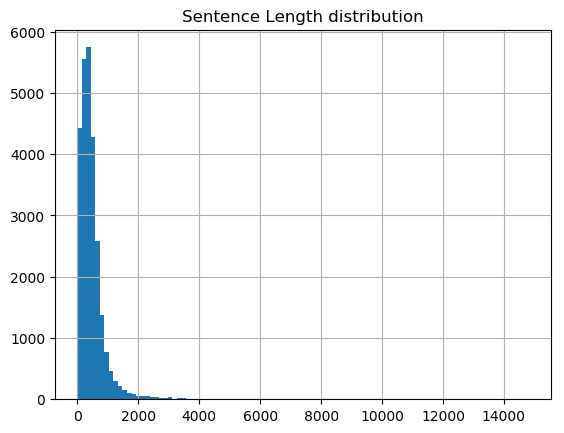

In [85]:
df["sent_len"].hist(bins=100)
plt.title("Sentence Length distribution")
plt.show()

Next we want to see the word-pair distributions of real/fake news respectively.  Interestingly, “donald trump” dominates the real news and “hillary clinton” dominates the fake news.

In [86]:
from collections import Counter
df_fake = df[df.labels==1]
df_real = df[df.labels==0]
num_to_show = 10

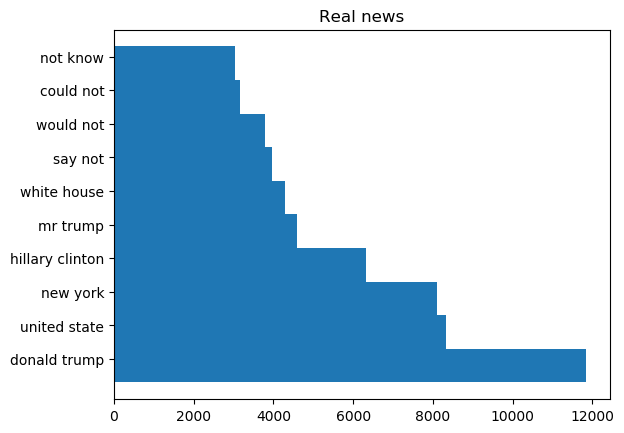

In [87]:
bigrams = nltk.bigrams([item for sublist in df_real["texts_tokens"].values for item in sublist])
counter = Counter(bigrams)
counter.most_common(num_to_show)
labels = [" ".join(e[0]) for e in counter.most_common(num_to_show)]
values = [e[1] for e in counter.most_common(num_to_show)]
plot_indexes = np.arange(len(labels))
width = 1
plt.barh(plot_indexes, values, width)
plt.yticks(plot_indexes + width * 0.2, labels)
plt.title("Real news")
plt.show()

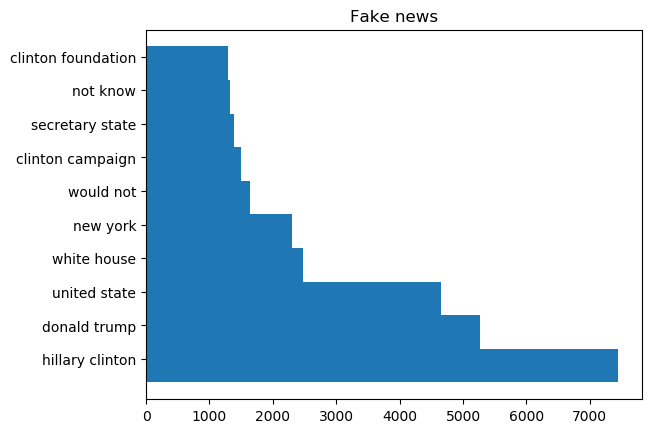

In [51]:
bigrams = nltk.bigrams([item for sublist in df_fake["texts_tokens"].values for item in sublist])
counter = Counter(bigrams)
counter.most_common(num_to_show)
labels = [" ".join(e[0]) for e in counter.most_common(num_to_show)]
values = [e[1] for e in counter.most_common(num_to_show)]
plot_indexes = np.arange(len(labels))
width = 1
plt.barh(plot_indexes, values, width)
plt.yticks(plot_indexes + width * 0.2, labels)
plt.title("Fake news")
plt.show()

We are going to repeat the the same analysis on the test set for:   
(1) Predicted false positives   
(2) Predicted false negatives   
(3) Predicted true positives   
(4) Predicted true negatives   

In [88]:
pred_test_label = pred_test>0.5
# predict true, but actually false
fp_logic_list = np.logical_and(pred_test_label,np.logical_not(y_test))
X_fp = X_test[fp_logic_list]

# predict false, but actually true
fn_logic_list = np.logical_and(y_test,np.logical_not(pred_test_label))
X_fn = X_test[fn_logic_list]

# predict true, and actually true
tp_logic_list = np.logical_and(y_test,pred_test_label)
X_tp = X_test[tp_logic_list]

# predict false, and actually false
tn_logic_list = np.logical_and(np.logical_not(y_test),\
                               np.logical_not(pred_test_label))
X_tn = X_test[tn_logic_list]

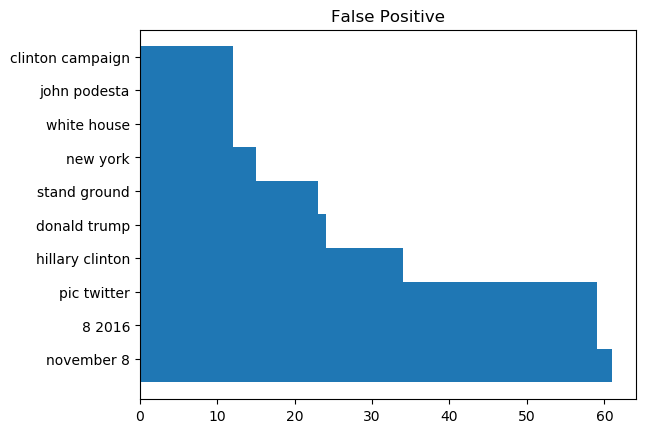

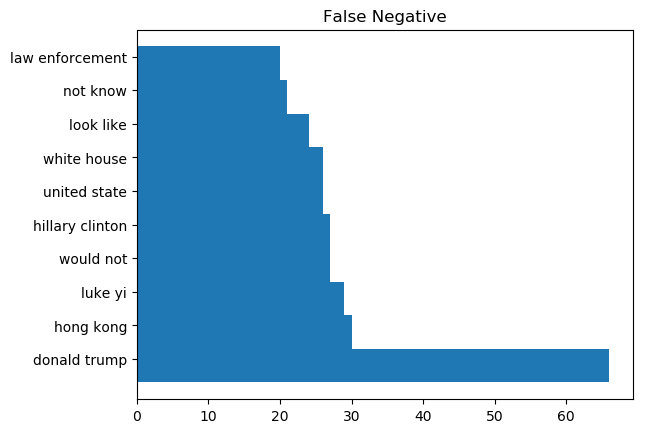

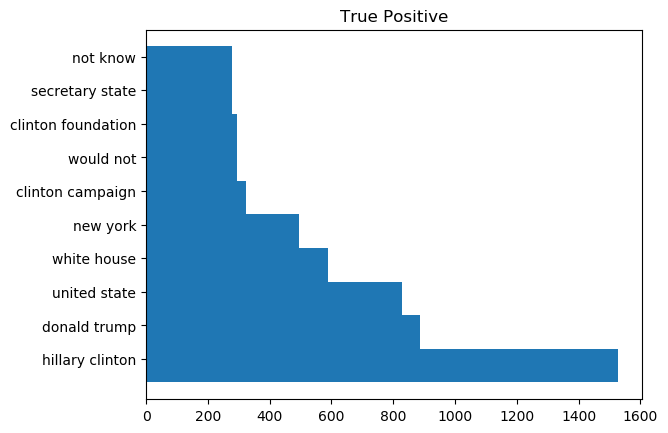

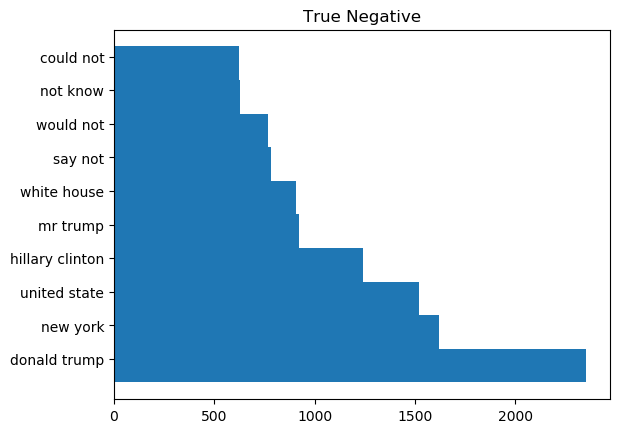

In [89]:
index_dict = {
            "False Positive":X_fp,
            "False Negative":X_fn,
            "True Positive":X_tp,
            "True Negative":X_tn
             }
num_to_show = 10
for k,sents in index_dict.items():
    tokens_list = [nltk.word_tokenize(sent) for sent in sents]
    bigrams = nltk.bigrams([item for sublist in tokens_list for item in sublist])
    counter = Counter(bigrams)
    labels = [" ".join(e[0]) for e in counter.most_common(num_to_show)]
    values = [e[1] for e in counter.most_common(num_to_show)]
    plot_indexes = np.arange(len(labels))
    width = 1
    plt.barh(plot_indexes, values, width)
    plt.yticks(plot_indexes + width * 0.2, labels)
    plt.title(k)
    plt.show()

Wonder what happens on November 8, 2016(top words in the false positive plot)? That turns out to be the US election day.